In [1]:
import sys, os, time
import logging
import torch
import pickle
import numpy as np
import cv2
sys.path.insert(0, '/home/rajeev-gupta/sensyn_ws/src/GD-MAE')


In [2]:
from pcdet.models.detectors import GraphRCNN
from pcdet.config import cfg, cfg_from_yaml_file
from pcdet.datasets.kitti.kitti_dataset import KittiDataset


In [3]:
log_path = './test_logs.txt'
cfg_file = '/home/rajeev-gupta/sensyn_ws/src/GD-MAE/tools/cfgs/kitti_models/graph_rcnn_voi.yaml'
ckpt_path = '/home/rajeev-gupta/sensyn_ws/src/GD-MAE/data/ckpts/graph_rcnn_voi_kitti.pth'
to_cpu = False

In [4]:
from pcdet.utils.calibration_nuscene import encircle_pixel_in_image, point_cloud_to_image, image_to_point_cloud, \
_point_cloud_to_image, _image_to_point_cloud


In [5]:
import open3d as o3d

def visualize_3d_points(points):
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    o3d.visualization.draw_geometries([point_cloud], window_name='3D Point Cloud',
                                      width=800, height=600, left=50, top=50,
                                      point_show_normal=False)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [6]:
#Logger
def create_logger(log_file=None, rank=0, log_level=logging.INFO):
    logger = logging.getLogger(__name__)
    logger.setLevel(log_level if rank == 0 else 'ERROR')
    formatter = logging.Formatter('%(asctime)s  %(levelname)5s  %(message)s')
    console = logging.StreamHandler()
    console.setLevel(log_level if rank == 0 else 'ERROR')
    console.setFormatter(formatter)
    logger.addHandler(console)
    if log_file is not None:
        file_handler = logging.FileHandler(filename=log_file)
        file_handler.setLevel(log_level if rank == 0 else 'ERROR')
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)
    logger.propagate = False
    return logger

In [7]:
def load_data_to_gpu(batch_dict):
    for key, val in batch_dict.items():
        if not isinstance(val, np.ndarray):
            continue
        elif key in ['frame_id', 'metadata', 'calib', 'image_shape', 'image_pad_shape', 'image_rescale_shape']:
            continue
        else:
            batch_dict[key] = torch.from_numpy(val).float().cuda()


In [8]:
logger = create_logger(log_path)

In [9]:
cfg_from_yaml_file(cfg_file, cfg)

{'ROOT_DIR': PosixPath('/home/rajeev-gupta/sensyn_ws/src/GD-MAE'),
 'LOCAL_RANK': 0,
 'CLASS_NAMES': ['Car'],
 'DATA_CONFIG': {'DATASET': 'KittiDataset',
  'DATA_PATH': '../data/kitti',
  'BACKEND': {'NAME': 'HardDiskBackend'},
  'POINT_CLOUD_RANGE': [0, -40, -3, 70.4, 40, 2],
  'DATA_SPLIT': {'train': 'train', 'test': 'test'},
  'INFO_PATH': {'train': ['kitti_infos_train.pkl'],
   'test': ['kitti_infos_test.pkl']},
  'GET_ITEM_LIST': ['points', 'image', 'calib_matricies', 'gt_boxes2d'],
  'FOV_POINTS_ONLY': True,
  'ENABLE_SIMILAR_TYPE': True,
  'DATA_AUGMENTOR': {'DISABLE_AUG_LIST': ['placeholder'],
   'AUG_CONFIG_LIST': [{'NAME': 'random_world_flip',
     'PROBABILITY': 0.5,
     'ALONG_AXIS_LIST': ['x']},
    {'NAME': 'random_world_rotation',
     'PROBABILITY': 1.0,
     'WORLD_ROT_ANGLE': [-0.78539816, 0.78539816]},
    {'NAME': 'random_world_scaling',
     'PROBABILITY': 1.0,
     'WORLD_SCALE_RANGE': [0.95, 1.05]}]},
  'POINT_FEATURE_ENCODING': {'encoding_type': 'absolute_coord

In [10]:
def get_calib_from_file(calib_file):
    lines = open(calib_file).readlines()

    obj = lines[2].strip().split(' ')[1:]
    P2 = np.array(obj, dtype=np.float32)
    obj = lines[3].strip().split(' ')[1:]
    P3 = np.array(obj, dtype=np.float32)
    obj = lines[4].strip().split(' ')[1:]
    R0 = np.array(obj, dtype=np.float32)
    obj = lines[5].strip().split(' ')[1:]
    Tr_velo_to_cam = np.array(obj, dtype=np.float32)

    return {'P2': P2.reshape(3, 4),
            'P3': P3.reshape(3, 4),
            'R0': R0.reshape(3, 3),
            'Tr_velo2cam': Tr_velo_to_cam.reshape(3, 4)}

def calib_to_matricies(calib):
    """
    Converts calibration object to transformation matricies
    Args:
        calib: calibration.Calibration, Calibration object
    Returns
        V2R: (4, 4), Lidar to rectified camera transformation matrix
        P2: (3, 4), Camera projection matrix
    """
    V2C = np.vstack((calib.V2C, np.array([0, 0, 0, 1], dtype=np.float32)))  # (4, 4)
    R0 = np.hstack((calib.R0, np.zeros((3, 1), dtype=np.float32)))  # (3, 4)
    R0 = np.vstack((R0, np.array([0, 0, 0, 1], dtype=np.float32)))  # (4, 4)
    V2R = R0 @ V2C
    P2 = calib.P2
    return V2R, P2

In [11]:
class Calibration(object):
    def __init__(self, calib_file):
        if not isinstance(calib_file, dict):
            calib = get_calib_from_file(calib_file)
        else:
            calib = calib_file

        self.P2 = calib['P2']  # 3 x 4
        self.R0 = calib['R0']  # 3 x 3
        self.V2C = calib['Tr_velo2cam']  # 3 x 4

        # Camera intrinsics and extrinsics
        self.cu = self.P2[0, 2]
        self.cv = self.P2[1, 2]
        self.fu = self.P2[0, 0]
        self.fv = self.P2[1, 1]
        self.tx = self.P2[0, 3] / (-self.fu)
        self.ty = self.P2[1, 3] / (-self.fv)

    def cart_to_hom(self, pts):
        """
        :param pts: (N, 3 or 2)
        :return pts_hom: (N, 4 or 3)
        """
        pts_hom = np.hstack((pts, np.ones((pts.shape[0], 1), dtype=np.float32)))
        return pts_hom

    def rect_to_lidar(self, pts_rect):
        """
        :param pts_lidar: (N, 3)
        :return pts_rect: (N, 3)
        """
        pts_rect_hom = self.cart_to_hom(pts_rect)  # (N, 4)
        R0_ext = np.hstack((self.R0, np.zeros((3, 1), dtype=np.float32)))  # (3, 4)
        R0_ext = np.vstack((R0_ext, np.zeros((1, 4), dtype=np.float32)))  # (4, 4)
        R0_ext[3, 3] = 1
        V2C_ext = np.vstack((self.V2C, np.zeros((1, 4), dtype=np.float32)))  # (4, 4)
        V2C_ext[3, 3] = 1

        pts_lidar = np.dot(pts_rect_hom, np.linalg.inv(np.dot(R0_ext, V2C_ext).T))
        return pts_lidar[:, 0:3]

    def lidar_to_rect(self, pts_lidar):
        """
        :param pts_lidar: (N, 3)
        :return pts_rect: (N, 3)
        """
        pts_lidar_hom = self.cart_to_hom(pts_lidar)
        pts_rect = np.dot(pts_lidar_hom, np.dot(self.V2C.T, self.R0.T))
        # pts_rect = reduce(np.dot, (pts_lidar_hom, self.V2C.T, self.R0.T))
        return pts_rect

    def rect_to_img(self, pts_rect):
        """
        :param pts_rect: (N, 3)
        :return pts_img: (N, 2)
        """
        pts_rect_hom = self.cart_to_hom(pts_rect)
        pts_2d_hom = np.dot(pts_rect_hom, self.P2.T)
        pts_img = (pts_2d_hom[:, 0:2].T / pts_rect_hom[:, 2]).T  # (N, 2)
        pts_rect_depth = pts_2d_hom[:, 2] - self.P2.T[3, 2]  # depth in rect camera coord
        return pts_img, pts_rect_depth

    def lidar_to_img(self, pts_lidar):
        """
        :param pts_lidar: (N, 3)
        :return pts_img: (N, 2)
        """
        pts_rect = self.lidar_to_rect(pts_lidar)
        pts_img, pts_depth = self.rect_to_img(pts_rect)
        return pts_img, pts_depth

    def img_to_rect(self, u, v, depth_rect):
        """
        :param u: (N)
        :param v: (N)
        :param depth_rect: (N)
        :return:
        """
        x = ((u - self.cu) * depth_rect) / self.fu + self.tx
        y = ((v - self.cv) * depth_rect) / self.fv + self.ty
        pts_rect = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1), depth_rect.reshape(-1, 1)), axis=1)
        return pts_rect

    def corners3d_to_img_boxes(self, corners3d):
        """
        :param corners3d: (N, 8, 3) corners in rect coordinate
        :return: boxes: (None, 4) [x1, y1, x2, y2] in rgb coordinate
        :return: boxes_corner: (None, 8) [xi, yi] in rgb coordinate
        """
        sample_num = corners3d.shape[0]
        corners3d_hom = np.concatenate((corners3d, np.ones((sample_num, 8, 1))), axis=2)  # (N, 8, 4)

        img_pts = np.matmul(corners3d_hom, self.P2.T)  # (N, 8, 3)

        x, y = img_pts[:, :, 0] / img_pts[:, :, 2], img_pts[:, :, 1] / img_pts[:, :, 2]
        x1, y1 = np.min(x, axis=1), np.min(y, axis=1)
        x2, y2 = np.max(x, axis=1), np.max(y, axis=1)

        boxes = np.concatenate((x1.reshape(-1, 1), y1.reshape(-1, 1), x2.reshape(-1, 1), y2.reshape(-1, 1)), axis=1)
        boxes_corner = np.concatenate((x.reshape(-1, 8, 1), y.reshape(-1, 8, 1)), axis=2)

        return boxes, boxes_corner
    
    def img_to_lidar(self, pts_img, pts_depth):
        pts_rect = self.img_to_rect(pts_img[:, 0], pts_img[:, 1], pts_depth)
        pts_lidar = self.rect_to_lidar(pts_rect)
        return pts_lidar


In [12]:
from pathlib import Path

import numpy as np
import torch.utils.data as torch_data

# from ..utils import common_utils, file_client
# from ..pcdet.datasets.augmentor.data_augmentor import DataAugmentor
from pcdet.datasets.processor.data_processor import DataProcessor
from pcdet.datasets.processor.point_feature_encoder import PointFeatureEncoder

class CustomKittiDataset(torch_data.Dataset):
    def __init__(self, dataset_cfg=None, class_names=None, training=True, root_path=None, logger=None):
        super().__init__()
        self.dataset_cfg = dataset_cfg
        self.training = training
        self.class_names = class_names
        self.logger = logger
        self.root_path = Path(root_path) if root_path is not None else Path(self.dataset_cfg.DATA_PATH)

        self.point_cloud_range = np.array(self.dataset_cfg.POINT_CLOUD_RANGE, dtype=np.float32)
        self.point_feature_encoder = PointFeatureEncoder(
            self.dataset_cfg.POINT_FEATURE_ENCODING,
            point_cloud_range=self.point_cloud_range
        )
        self.data_processor = DataProcessor(
            self.dataset_cfg.DATA_PROCESSOR, point_cloud_range=self.point_cloud_range,
            training=self.training, num_point_features=self.point_feature_encoder.num_point_features
        )
        self.grid_size = self.data_processor.grid_size
        self.voxel_size = self.data_processor.voxel_size
        self.total_epochs = 0
        self.cur_epoch = 0
        self._merge_all_iters_to_one_epoch = False

    @property
    def mode(self):
        return 'train' if self.training else 'test'
        
    def __getitem__(self, index):
        info_path = '/media/rajeev-gupta/Drive250/SENSYN_/data/kitti/kitti_infos_test.pkl'
        with open(info_path, 'rb') as i_file:
            i_dict = pickle.load(i_file)
        if index > -1:
            info = i_dict[index]
        else:
            info = None
        if info == None:
            sample_idx = str(-index)
            img_shape =  (384, 1280)
        else:
            sample_idx = info['point_cloud']['lidar_idx']
            # img_shape = info['image']['image_shape']
        
        calib = self.get_calib(sample_idx)
        get_item_list = self.dataset_cfg.get('GET_ITEM_LIST', ['points'])

        input_dict = {
            'frame_id': sample_idx,
            'calib': calib,
        }

        if "image" in get_item_list:
            input_dict['image'] = self.get_image(sample_idx)
            img_shape = input_dict['image'].shape[:2]
            input_dict['image_shape'] = img_shape

        if "points" in get_item_list:
            points = self.get_lidar(sample_idx)
            if self.dataset_cfg.FOV_POINTS_ONLY:
                pts_rect = calib.lidar_to_rect(points[:, 0:3])
                ## saving pts_rect to bin 
                # pts_rect.tofile('./new_points_wo.bin')
                fov_flag = self.get_fov_flag(pts_rect, img_shape, calib)
                points = points[fov_flag]
                self.logger.info(f'point cloud shape after field of view cropping: {points.shape}')
            input_dict['points'] = points

        if "calib_matricies" in get_item_list:
            input_dict["trans_lidar_to_cam"], input_dict["trans_cam_to_img"] = calib_to_matricies(calib)

        data_dict = self.prepare_data(data_dict=input_dict)

        # data_dict['image_shape'] = img_shape
        return data_dict
    
    def get_calib(self, idx):
        calib_file = self.root_path / 'testing' / 'calib' / ('%s.txt' % idx)
        return Calibration(calib_file)

    def get_lidar(self, idx):
        lidar_file = self.root_path / 'testing' / 'velodyne' / ('%s.bin' % idx)
        points = np.fromfile(lidar_file, dtype=np.float32).reshape(-1, 4)
        self.logger.info(f'point cloud shape after loading: {points.shape}')
        return points
    
    def get_image(self, idx):
        img_file = self.root_path / 'testing' / 'image_2' / ('%s.png' % idx)
        image = cv2.imread(str(img_file), cv2.IMREAD_COLOR)
        if image.shape[0] > 384 and image.shape[1] > 1280:
            image = image[448:832, 320:1600]
        return image
    
    def prepare_data(self, data_dict):
        if data_dict.get('points', None) is not None:
            data_dict = self.point_feature_encoder.forward(data_dict)

        data_dict = self.data_processor.forward(
            data_dict=data_dict
        )
        points = data_dict['points']
        self.logger.info(f'point cloud shape after processing: {points.shape}')
        return data_dict

    @staticmethod
    def get_fov_flag(pts_rect, img_shape, calib):
        """
        Args:
            pts_rect:
            img_shape:
            calib:

        Returns:

        """
        pts_img, pts_rect_depth = calib.rect_to_img(pts_rect)
        val_flag_1 = np.logical_and(pts_img[:, 0] >= 0, pts_img[:, 0] < img_shape[1])
        val_flag_2 = np.logical_and(pts_img[:, 1] >= 0, pts_img[:, 1] < img_shape[0])
        pts_valid_flag = np.logical_and(val_flag_1, val_flag_2)
        pts_valid_flag = np.logical_and(pts_valid_flag, pts_rect_depth >= 0)
        return pts_valid_flag


In [13]:
dataset = CustomKittiDataset(
        dataset_cfg=cfg.DATA_CONFIG,
        class_names=cfg.CLASS_NAMES,
        root_path='/home/rajeev-gupta/sensyn_ws/src/GD-MAE/data/kitti',
        training=False,
        logger=logger,
    )

In [14]:
# dataset = KittiDataset(
#         dataset_cfg=cfg.DATA_CONFIG,
#         class_names=cfg.CLASS_NAMES,
#         root_path=None,
#         training=False,
#         logger=logger,
#     )

In [15]:
# with open('/home/rajeev-gupta/sensyn_ws/src/GD-MAE/tools/batch_dict_22', 'rb') as b_file:
#     b_dict = pickle.load(b_file)
# print(type(b_dict))
# b_dict

In [16]:
data_number = 47
get_dict = dataset.__getitem__(data_number)


2024-07-22 12:53:58,233   INFO  point cloud shape after loading: (122520, 4)
2024-07-22 12:53:58,252   INFO  point cloud shape after field of view cropping: (19583, 4)


2024-07-22 12:53:58,265   INFO  point cloud shape after processing: (19552, 4)


In [17]:
get_dict

{'frame_id': '000047',
 'calib': <__main__.Calibration at 0x7efed1afa250>,
 'image': array([[[ 2.0513566 ,  2.0169408 ,  1.8202497 ],
         [ 2.0513566 ,  2.0169408 ,  1.8343511 ],
         [ 2.0513566 ,  2.0169408 ,  1.8907566 ],
         ...,
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],
 
        [[ 2.0513566 ,  2.0169408 ,  1.8202497 ],
         [ 2.0513566 ,  2.0169408 ,  1.8202497 ],
         [ 2.0513566 ,  2.0169408 ,  1.8766552 ],
         ...,
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],
 
        [[ 2.0513566 ,  2.0169408 ,  1.904858  ],
         [ 2.0513566 ,  2.0169408 ,  1.8907566 ],
         [ 2.0513566 ,  2.0169408 ,  1.904858  ],
         ...,
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.     

In [18]:
get_dict['points'].shape

(19552, 4)

In [19]:
# visualize_3d_points(get_dict['points'])

In [20]:
for key, val in get_dict.items():
    print(key)
    if type(val) == tuple:
        get_dict[key] = list(val)
    elif key == 'points':
        # add a zero column
        n = val.shape[0]
        z_col = np.zeros((n, 1), dtype=float)
        get_dict[key] = np.concatenate((z_col, val), axis = 1)
        # setting reflectance to 1
        # get_dict[key][:, 4] = 1
        # get_dict[key] = np.concatenate((get_dict[key], np.ones((get_dict[key].shape[0], 1))), axis=1)
        continue
    elif key == 'image':
        # transpose (384, 1280, 3) to (3, 384, 1280)
        val_transposed = np.transpose(val, (2, 0, 1))
        get_dict[key] = val_transposed
        # print(get_dict[key].shape)
    elif key == 'transformation_2d_list' or key == 'transformation_2d_params':
        get_dict[key] = [val]
        continue
    get_dict[key] = np.array([get_dict[key]])
            
get_dict['batch_size'] = 1



frame_id
calib
image
image_shape
points
trans_lidar_to_cam
trans_cam_to_img
use_lead_xyz
transformation_2d_list
transformation_2d_params
image_rescale_shape
image_pad_shape


In [21]:
get_dict

{'frame_id': array(['000047'], dtype='<U6'),
 'calib': array([<__main__.Calibration object at 0x7efed1afa250>], dtype=object),
 'image': array([[[[ 2.0513566 ,  2.0513566 ,  2.0513566 , ...,  0.        ,
            0.        ,  0.        ],
          [ 2.0513566 ,  2.0513566 ,  2.0513566 , ...,  0.        ,
            0.        ,  0.        ],
          [ 2.0513566 ,  2.0513566 ,  2.0513566 , ...,  0.        ,
            0.        ,  0.        ],
          ...,
          [-0.35343668, -0.28550467, -0.25833187, ...,  0.        ,
            0.        ,  0.        ],
          [-0.31267747, -0.21757266, -0.17681344, ...,  0.        ,
            0.        ,  0.        ],
          [-0.29909107, -0.20398624, -0.17681344, ...,  0.        ,
            0.        ,  0.        ]],
 
         [[ 2.0169408 ,  2.0169408 ,  2.0169408 , ...,  0.        ,
            0.        ,  0.        ],
          [ 2.0169408 ,  2.0169408 ,  2.0169408 , ...,  0.        ,
            0.        ,  0.        ]

In [22]:
# image_arr = _point_cloud_to_image(get_dict['calib'][0], l_points, get_dict['image_shape'][0], point_radii=4, to_show=True, bg_shade=[0, 0, 0])


In [23]:
# with open('./get_dict.pkl', 'wb') as gd_file:
#     pickle.dump(get_dict, gd_file)

In [24]:
get_dict['image'][0][0].dtype

dtype('float32')

In [25]:
get_dict['image'].shape

(1, 3, 384, 1280)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


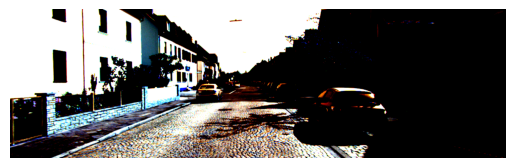

In [26]:
import matplotlib.pyplot as plt
img = get_dict['image']
# img = cv2.cvtColor(np.transpose(img[0], (1, 2, 0)), cv2.COLOR_BGR2RGB)
img = np.transpose(img[0], (1, 2, 0))
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

In [27]:
get_dict['points']

array([[ 0.00000000e+00,  6.95989990e+01,  1.03920002e+01,
         2.58899999e+00,  0.00000000e+00],
       [ 0.00000000e+00,  6.89369965e+01,  1.05150003e+01,
         2.56699991e+00,  0.00000000e+00],
       [ 0.00000000e+00,  6.47050018e+01,  1.02840004e+01,
         2.42499995e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  6.44199991e+00, -5.20000011e-02,
        -1.68400002e+00,  2.50000000e-01],
       [ 0.00000000e+00,  6.45200014e+00, -3.20000015e-02,
        -1.68700004e+00,  1.70000002e-01],
       [ 0.00000000e+00,  6.45499992e+00, -1.20000001e-02,
        -1.68799996e+00,  2.59999990e-01]])

In [28]:
get_dict['points'].shape

(19552, 5)

(19552, 2) 0.20562040049587033 1241.9305287935354 126.4460580490716 374.9905998005301


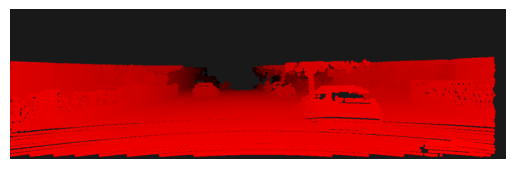

In [29]:
image_arr = point_cloud_to_image(get_dict, point_radii=4, 
                                 bg_shade=[0.10, 0.10, 0.10], fill_depth_as_pixel_value=True)
                                #  bg_shade=[0, 0, 0])

In [30]:
image_arr.shape 

(384, 1272, 4)

In [31]:
calib = get_dict['calib'][0]
pts_rect = calib.lidar_to_rect(get_dict['points'][:, 1:4])
pts_rect[0], pts_rect.dtype
pts_rect = pts_rect.astype(np.float32)
pts_img, pts_depth = calib.lidar_to_img(pts_rect)


In [32]:
pts_img.shape, pts_img[0]

((19552, 2), array([ 526.1119, 5215.002 ], dtype=float32))

tried to downsample image and then convert back to points: after the conversion PC seems like stacking of images in 3d at some distance


In [33]:
# scale_factor = 1
# new_size = (int(image_arr.shape[1]*scale_factor), int(image_arr.shape[0]*scale_factor))
# reduced_image_arr = cv2.resize(image_arr, new_size, interpolation=cv2.INTER_LINEAR)
# plt.imshow(reduced_image_arr)
# plt.axis('off')  # Optional: turn off axis
# plt.show()

In [34]:
# reduced_image_arr.shape

In [35]:
# reduced_image_arr

In [36]:
# new_points = _image_to_point_cloud(get_dict['calib'][0], reduced_image_arr)
# new_points

np.random sampling lidar points

In [37]:
points = get_dict['points']
percentage_to_keep = 0.2
num_points_to_keep = int(points.shape[0] * percentage_to_keep)
indices = np.random.choice(points.shape[0], num_points_to_keep, replace=False)
new_points = points[indices]

In [38]:
# new_points = np.concatenate((np.zeros((new_points.shape[0], 1)), new_points, np.ones((new_points.shape[0], 1))), axis=1)
# new_points[0]

In [39]:
# new_points = new_points.astype(np.float32)
# new_points[:, 1:4].tofile('./new_points_kt.bin')

In [40]:
new_points.shape

(3910, 5)

In [41]:
get_dict['points'] = new_points

(3910, 2) 0.20562040049587033 1241.806850522217 127.03074402818218 374.5822841359426


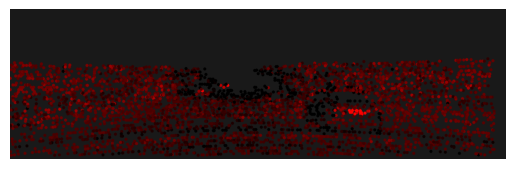

In [42]:
image_arr = point_cloud_to_image(get_dict, point_radii=4, 
                                 bg_shade=[0.10, 0.10, 0.10])
                                #  bg_shade=[0, 0, 0])

In [43]:
image_arr.shape

(384, 1272, 4)

In [44]:
cfg.CLASS_NAMES

['Car']

In [45]:
model = GraphRCNN(cfg.MODEL, num_class=len(cfg.CLASS_NAMES), dataset=dataset, logger=logger)

/media/rajeev-gupta/Drive250/conda_envs/new_graphrcnn/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180589158/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
2024-07-22 12:54:03,644   INFO  DLASeg is freezed
2024-07-22 12:54:03,645   INFO  DynVFE is freezed
2024-07-22 12:54:03,647   INFO  VoxelBackBone8x is freezed
2024-07-22 12:54:03,647   INFO  HeightCompression is freezed
2024-07-22 12:54:03,648   INFO  BaseBEVBackbone is freezed
2024-07-22 12:54:03,649   INFO  AnchorHeadSingle is freezed


In [46]:
with torch.no_grad():
    model.load_params_from_file(filename=ckpt_path, logger=logger, to_cpu=to_cpu)
    model.cuda()
    model.eval()
    time.sleep(2)


2024-07-22 12:54:03,654   INFO  ==> Loading parameters from checkpoint /home/rajeev-gupta/sensyn_ws/src/GD-MAE/data/ckpts/graph_rcnn_voi_kitti.pth to GPU
2024-07-22 12:54:03,723   INFO  ==> Done (loaded 518/518)


In [47]:
data_input = get_dict

In [48]:
data_input = get_dict
# data_input = b_dict
torch.cuda.synchronize()
start_time = time.time()
load_data_to_gpu(data_input)
pred_dicts, ret_dict = model(data_input)
torch.cuda.synchronize()
end_time = time.time()
print('Inference Time: ', end_time-start_time)

pred_dicts

Inference Time:  0.5304360389709473


[{'pred_boxes': tensor([[ 9.7771, -2.8734, -0.9900,  3.4762,  1.5486,  1.4202,  6.2988],
          [23.8939, -2.7059, -1.0100,  3.8610,  1.5550,  1.3817,  6.3684],
          [49.0800,  3.5654, -1.0076,  3.5599,  1.6163,  1.5096,  6.0660],
          [24.5222,  3.5802, -1.0396,  3.7054,  1.5581,  1.3617,  6.2253]],
         device='cuda:0', grad_fn=<IndexBackward0>),
  'pred_scores': tensor([0.9654, 0.7592, 0.5423, 0.3525], device='cuda:0',
         grad_fn=<IndexBackward0>),
  'pred_labels': tensor([1, 1, 1, 1], device='cuda:0')}]

In [49]:
pred_boxes = pred_dicts[0]['pred_boxes'].cpu().detach().numpy()
pred_boxes

array([[ 9.777081 , -2.8734086, -0.9899814,  3.4761822,  1.5486236,
         1.4202288,  6.2988305],
       [23.893867 , -2.7059238, -1.0099654,  3.8609593,  1.5549717,
         1.3817136,  6.368425 ],
       [49.08001  ,  3.565445 , -1.0076295,  3.559852 ,  1.6162717,
         1.5096116,  6.0660095],
       [24.522202 ,  3.5801544, -1.0396123,  3.7054372,  1.5581303,
         1.3616976,  6.2252765]], dtype=float32)

In [50]:
index = f'{data_number:06d}'

In [51]:
image_bgr = dataset.get_image(index)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [52]:
image_bgr[0][0], image_rgb[0][0]

(array([255, 255, 249], dtype=uint8), array([249, 255, 255], dtype=uint8))

In [53]:
image_rgb = image_rgb / 255
image_bgr = image_bgr / 255
image_bgr[0]

array([[1.        , 1.        , 0.97647059],
       [1.        , 1.        , 0.98039216],
       [1.        , 1.        , 0.99607843],
       ...,
       [0.17254902, 0.14117647, 0.11764706],
       [0.18823529, 0.18431373, 0.15294118],
       [0.17254902, 0.24313725, 0.22352941]])

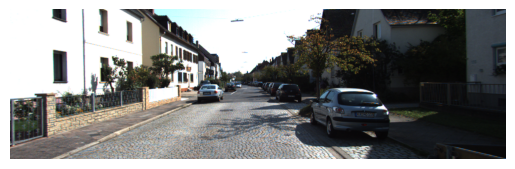

In [54]:
import matplotlib.pyplot as plt
plt.imshow(image_rgb)
# plt.imshow(image_bgr)
plt.axis('off')  # Hide the axis
plt.show()

In [55]:
calib = dataset.get_calib(index)
cam_to_img = calib.P2

In [56]:
cam_to_img

array([[7.215377e+02, 0.000000e+00, 6.095593e+02, 4.485728e+01],
       [0.000000e+00, 7.215377e+02, 1.728540e+02, 2.163791e-01],
       [0.000000e+00, 0.000000e+00, 1.000000e+00, 2.745884e-03]],
      dtype=float32)

In [57]:
def boxes3d_lidar_to_kitti_camera(boxes3d_lidar, calib):
    """
    :param boxes3d_lidar: (N, 7) [x, y, z, dx, dy, dz, heading], (x, y, z) is the box center
    :param calib:
    :return:
        boxes3d_camera: (N, 7) [x, y, z, l, h, w, r] in rect camera coords
    """
    import copy
    boxes3d_lidar_copy = copy.deepcopy(boxes3d_lidar)
    xyz_lidar = boxes3d_lidar_copy[:, 0:3]
    l, w, h = boxes3d_lidar_copy[:, 3:4], boxes3d_lidar_copy[:, 4:5], boxes3d_lidar_copy[:, 5:6]
    r = boxes3d_lidar_copy[:, 6:7]

    xyz_lidar[:, 2] -= h.reshape(-1) / 2
    xyz_cam = calib.lidar_to_rect(xyz_lidar)
    # xyz_cam[:, 1] += h.reshape(-1) / 2
    r = -r - np.pi / 2
    return np.concatenate([xyz_cam, l, h, w, r], axis=-1)


In [58]:
# convert lidar boxes to camera frame
pred_boxes_cam = boxes3d_lidar_to_kitti_camera(pred_boxes, calib)
pred_boxes_cam[0]

array([ 2.8907056,  1.6966056,  9.486288 ,  3.4761822,  1.4202288,
        1.5486236, -7.869627 ], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


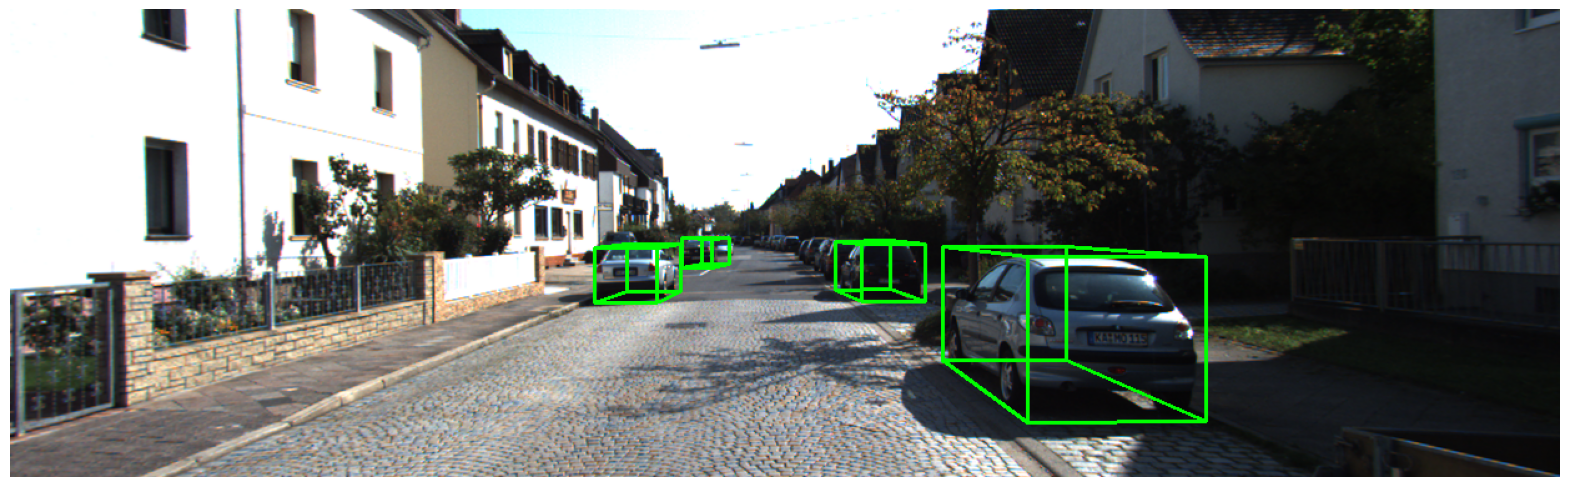

In [59]:
# Draw 3D Bounding Box
import copy
image_with_boxes = copy.deepcopy(image_rgb)
for line in pred_boxes_cam[:]:
# for line in [pred_boxes_cam[3]]:
    dims   = np.asarray([float(number) for number in line[3:6]])
    ## swap x, y, only required when reading from GD-MAE test - txt results
    tmp = dims[1]
    dims[1]=dims[0]
    dims[0]=tmp
    center = np.asarray([float(number) for number in line[0:3]])
    rot_y  = float(line[3]) + np.arctan(center[0]/center[2])#float(line[14])
    # rot_y  = float(line[3]) + float(line[6]) + np.arctan(center[0]/center[2])
    # rot_y = 0
    rot_y = float(line[6]) + 1.57
    box_3d = []
    for i in [1,-1]:
        for j in [1,-1]:
            for k in [0,1]:
                point = np.copy(center)
                point[0] = center[0] + i * dims[1]/2 * np.cos(-rot_y+np.pi/2) + (j*i) * dims[2]/2 * np.cos(-rot_y)
                point[2] = center[2] + i * dims[1]/2 * np.sin(-rot_y+np.pi/2) + (j*i) * dims[2]/2 * np.sin(-rot_y)                  
                point[1] = center[1] - k * dims[0]
                point = np.append(point, 1)
                point = np.dot(cam_to_img, point)
                point = point[:2]/point[2]
                point = point.astype(np.int16)
                box_3d.append(point)
    for i in range(4):
        point_1_ = box_3d[2*i]
        point_2_ = box_3d[2*i+1]
        cv2.line(image_with_boxes, (point_1_[0], point_1_[1]), (point_2_[0], point_2_[1]), (0,255,0), 2)
    for i in range(8):
        point_1_ = box_3d[i]
        point_2_ = box_3d[(i+2)%8]
        cv2.line(image_with_boxes, (point_1_[0], point_1_[1]), (point_2_[0], point_2_[1]), (0,255,0), 2)

# Display the image using matplotlib
plt.figure(figsize=(20, 10))

plt.imshow(image_with_boxes)
plt.axis('off')  # Hide the axis
plt.show()

In [60]:
type(dataset.__getitem__(0))

2024-07-22 12:54:07,032   INFO  point cloud shape after loading: (125635, 4)
2024-07-22 12:54:07,045   INFO  point cloud shape after field of view cropping: (20528, 4)
2024-07-22 12:54:07,058   INFO  point cloud shape after processing: (20484, 4)


dict

In [61]:
# Inference Time:  0.5571572780609131
# [{'pred_boxes': tensor([[37.4968, 15.7908, -0.4055,  3.6946,  1.6049,  1.5020,  3.2492]],
#          device='cuda:0', grad_fn=<IndexBackward0>),
#   'pred_scores': tensor([0.4828], device='cuda:0', grad_fn=<IndexBackward0>),
#   'pred_labels': tensor([1], device='cuda:0')}]

In [62]:
info_path = '/home/rajeev-gupta/sensyn_ws/src/GD-MAE/data/kitti/kitti_infos_test.pkl'
with open(info_path, 'rb') as i_file:
    i_dict = pickle.load(i_file)
len(i_dict)

51

In [63]:
i_dict[0]


{'point_cloud': {'num_features': 4, 'lidar_idx': '000000'},
 'image': {'image_idx': '000000',
  'image_shape': array([ 375, 1242], dtype=int32)},
 'calib': {'P2': array([[7.21537720e+02, 0.00000000e+00, 6.09559326e+02, 4.48572807e+01],
         [0.00000000e+00, 7.21537720e+02, 1.72854004e+02, 2.16379106e-01],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 2.74588400e-03],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
  'R0_rect': array([[ 0.9999239 ,  0.00983776, -0.00744505,  0.        ],
         [-0.0098698 ,  0.9999421 , -0.00427846,  0.        ],
         [ 0.00740253,  0.00435161,  0.9999631 ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  1.        ]],
        dtype=float32),
  'Tr_velo_to_cam': array([[ 7.53374491e-03, -9.99971390e-01, -6.16602018e-04,
          -4.06976603e-03],
         [ 1.48024904e-02,  7.28073297e-04, -9.99890208e-01,
          -7.63161778e-02],
         [ 9.99862075e-01,  7.52379000e-03,  1.480755

In [64]:
# import os

# def process_file(file_path, keyword):
#     if not os.path.isfile(file_path):
#         print(f"The file {file_path} does not exist.")
#         return
    
#     # Read the file content
#     with open(file_path, 'r') as file:
#         lines = file.readlines()
#     save_path = file_path[:-3] + '2' + file_path[-3:]
#     base_name = os.path.basename(file_path)
#     # Find lines containing the keyword
#     line_dict = {index: line for index, line in enumerate(lines) if keyword in line}

#     # Insert comments below each found line
#     for index in sorted(line_dict.keys(), reverse=True):  # Process in reverse order to avoid shifting lines
#         line = line_dict[index][:-1]
#         i = 0
#         while(line[i]==' '):
#             i+=1
#         j = i
#         while(line[j]!='('):
#             j+=1
#         lines.insert(index + 1, f"{line[:i]}    print('from {base_name}: {line[i:j]} ******************')\n")

#     # Write the modified content back to the file
#     with open(save_path, 'w') as file:
#         file.writelines(lines)

#     print(f"Processed file {file_path} successfully.")


In [65]:
# import os

# def process_file_del(file_path, keyword):
#     if not os.path.isfile(file_path):
#         print(f"The file {file_path} does not exist.")
#         return
    
#     # Read the file content
#     with open(file_path, 'r') as file:
#         lines = file.readlines()
#     save_path = file_path[:-3] + '2' + file_path[-3:]
#     # Find lines containing the keyword
#     line_dict = {index: line for index, line in enumerate(lines) if keyword in line}

#     # Insert comments below each found line
#     for index in sorted(line_dict.keys(), reverse=True):  # Process in reverse order to avoid shifting lines
#         del lines[index]
#     # Write the modified content back to the file
#     with open(save_path, 'w') as file:
#         file.writelines(lines)

#     print(f"Processed file {file_path} successfully.")


In [66]:

# file_path = '/home/rajeev-gupta/sensyn_ws/src/GD-MAE/pcdet/datasets/kitti/kitti_dataset.py'  # Replace with your file path
# keyword = '******************\')'
# process_file_del(file_path, keyword)


In [67]:

# file_path = '/home/rajeev-gupta/sensyn_ws/src/GD-MAE/pcdet/datasets/dataset.py'  # Replace with your file path
# keyword = '******************\')'
# process_file_del(file_path, keyword)


In [68]:
# file_path = '/home/rajeev-gupta/sensyn_ws/src/GD-MAE/pcdet/models/detectors/detector3d_template.py'  # Replace with your file path
# keyword = '******************\')'
# process_file_del(file_path, keyword)


In [69]:
# file_path = '/home/rajeev-gupta/sensyn_ws/src/GD-MAE/pcdet/datasets/processor/data_processor.py'  # Replace with your file path
# keyword = '******************\')'
# process_file_del(file_path, keyword)


In [70]:
points_from_file = np.fromfile('/home/rajeev-gupta/sensyn_ws/src/GD-MAE/data/kitti/testing/velodyne/000001.bin', dtype=np.float32).reshape(-1, 4)
points_from_file

array([[ 30.458,   5.764,   1.257,   0.08 ],
       [ 30.479,   5.867,   1.259,   0.09 ],
       [ 30.504,   5.971,   1.26 ,   0.08 ],
       ...,
       [  3.623,  -1.35 ,  -1.687,   0.   ],
       [ 48.312, -15.616, -23.559,   0.   ],
       [ 48.399, -15.56 , -23.589,   0.   ]], dtype=float32)

In [71]:
points_from_file.shape

(122109, 4)